### Project Goals

In this project the goals is analysis a biodiversity for the National Parks Service. The National Park Service wants to ensure the survival of at-risk species, to maintain the level of biodiversity within their parks. Therefore, the main objectives will be understanding characteristics about the species and their conservations status, and those species and their relationship to the national parks. Some questions that are posed:

- What is the distribution of conservation status for species?
- Are certain types of species more likely to be endangered?
- Are the differences between species and their conservation status significant?
- Which animal is most prevalent and what is their distribution amongst parks?

### Analysis

In this section, descriptive statistics and data visualization techniques will be employed to understand the data better. Statistical inference will also be used to test if the observed values are statistically significant. Some of the key metrics that will be computed include: 

1. Distributions
2. Counts
3. Relationship between species
4. Conservation status of species
5. Observations of species in parks. 

### Evaluation

Lastly, it's a good idea to revisit the goals and check if the output of the analysis corresponds to the questions first set to be answered (in the goals section). This section will answer if any of the questions were unable to be answered. This could also include limitations or if any of the analysis could have been done using different methodologies.

In [88]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from scipy.stats import chi2_contingency

from itertools import chain

#pandas adjustments
pd.set_option('display.width', 1000) 
# pd.reset_option('display.width')

#### Species

The `species_info.csv` contains information on the different species in the National Parks. The columns in the data set include:
- **category** - The category of taxonomy for each species
- **scientific_name** - The scientific name of each species
- **common_names** - The common names of each species
- **conservation_status** - The species conservation status

In [39]:
species = pd.read_csv("species_info.csv")
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


#### Observations

The `Observations.csv` contains information from recorded sightings of different species throughout the national parks in the past 7 days. The columns included are:

- **scientific_name** - The scientific name of each species
- **park_name** - The name of the national park
- **observations** - The number of observations in the past 7 days

In [40]:
observations = pd.read_csv("observations.csv")
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


## EDA

### Species

In [41]:
print(f"Shape of species data: {species.shape}")

print("Species data describe")
species.describe(include='all')

Shape of species data: (5824, 4)
Species data describe


,category,scientific_name,common_names,conservation_status
count,5824,5824,5824,191
unique,7,5541,5504,4
top,Vascular Plant,Procyon lotor,Brachythecium Moss,Species of Concern
freq,4470,3,7,161


We can see that the columns ‘category’, ‘scientific_name’, ‘common_names’ are fully completed, but the column ‘conservation_status’ has many missings.
We can also see that the data consists of 7 categories and that some of the data in the ‘scientific_name’ column is duplicated.

In [43]:
# dropping rows with duplicated scientific_name, conservation_status leaving the records with the most in common_names
species['common_names_length'] = species['common_names'].apply(lambda x: len(x))
species = species.sort_values(
    by=['scientific_name', 'conservation_status', 'common_names_length'],
    ascending=[True, True, False]
).drop(columns='common_names_length')

species = species.drop_duplicates(['scientific_name', 'conservation_status']).reset_index(drop=True)

In order not to duplicate information on individual species, records with duplicate species names have been removed, leaving those records with more names in the common_names column.

In [42]:
species['conservation_status'].unique()

array([nan, 'Species of Concern', 'Endangered', 'Threatened',
       'In Recovery'], dtype=object)

We can see that we have 4 types of conservation status designation and one is no status meaning no conservation action.

### Observations

In [45]:
print(f"Shape of observations data: {observations.shape}")

print("Observations data describe")
observations.describe(include='all')

Shape of observations data: (23296, 3)
Observations data describe


,scientific_name,park_name,observations
count,23296,23296,23296.000000
unique,5541,4,NaN
top,Puma concolor,Great Smoky Mountains National Park,NaN
freq,12,5824,NaN
mean,NaN,NaN,142.287904
std,NaN,NaN,69.890532
min,NaN,NaN,9.000000
25%,NaN,NaN,86.000000
50%,NaN,NaN,124.000000
75%,NaN,NaN,195.000000


We can see that we do not have any missing cells in the Observations table.
It is worth noting that all observations refer to 4 parks.

## Analysis

Analyzing the data after the initial exploration. First task will be to clean and explore the `conservation_status` column in `species`. 

The column `conservation_status` has several possible values:
- `Species of Concern`: declining or appear to be in need of conservation
- `Threatened`: vulnerable to endangerment in the near future
- `Endangered`: seriously at risk of extinction
- `In Recovery`: formerly `Endangered`, but currently neither in danger of extinction throughout all or a significant portion of its range

In the exploration, a lot of `nan` values were detected. These values will need to be converted to `No Action`.

In [46]:
species['conservation_status'] = species['conservation_status'].fillna('No Action')

species['conservation_status'].value_counts()

conservation_status
No Action             5363
Species of Concern     151
Endangered              15
Threatened              10
In Recovery              4
Name: count, dtype: int64

In [47]:
species_conversation_category = species[species['conservation_status'] != 'No Action'].groupby(['conservation_status', 'category'])['scientific_name'].size().unstack()
species_conversation_category

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,6.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,68.0,4.0,22.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


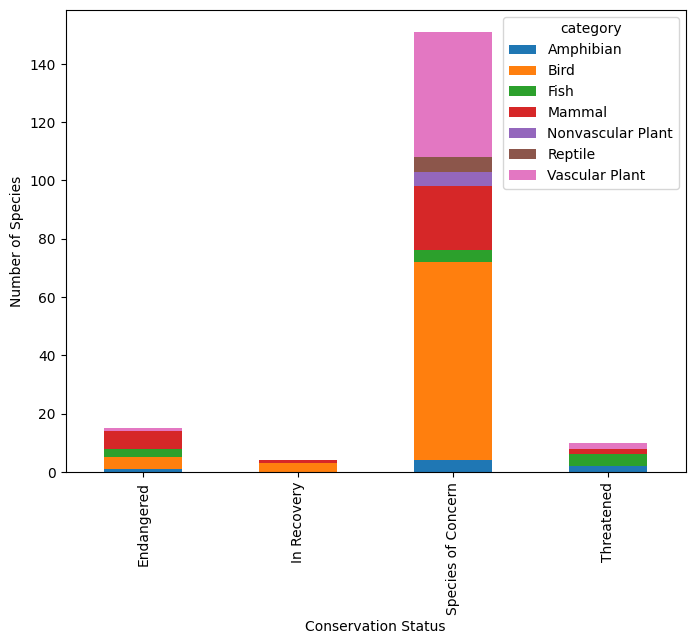

In [48]:
ax = species_conversation_category.plot(kind = 'bar', figsize=(8,6), stacked=True)

ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species");

#### In conservation

The next question is if certain types of species are more likely to be endangered? 

In [49]:
species['is_protected'] = species['conservation_status'] != 'No Action'

protected_species_by_category = species.groupby(['category', 'is_protected'])['scientific_name'].count().unstack().reset_index()
protected_species_by_category.columns = ['Category','Not Protected', 'Protected']

protected_species_by_category['Percent_Protected'] = round(protected_species_by_category['Protected'] / (protected_species_by_category['Protected'] + protected_species_by_category['Not Protected']) * 100, 2)

protected_species_by_category

,Category,Not Protected,Protected,Percent_Protected
0,Amphibian,72,7,8.86
1,Bird,413,75,15.37
2,Fish,115,11,8.73
3,Mammal,146,31,17.51
4,Nonvascular Plant,328,5,1.50
5,Reptile,73,5,6.41
6,Vascular Plant,4216,46,1.08


#### Statistical Significance

This section will run some chi-squared tests to see if different species have statistically significant differences in conservation status rates. In order to run a chi squared test, a contingency table will need to be created. The contingency table should look like this:

||protected|not protected|
|-|-|-|
|Mammal|?|?|
|Bird|?|?|

The first test will be called `contingency1` and will need to be filled with the correct numbers for mammals and birds.

In [50]:
contingency1 = [[31, 146],
              [75, 413]]


chi2, pval, dof, expected = chi2_contingency(contingency1)

print(pval)

0.583638782116612


The result from the chi-squared test returned the p-value which is 0.58. The standard p-value to test statistical significance is 0.05. For the value retrieved from this test (0.58) is much larger than 0.05. In the case of mammals and birds there doesn't seem to be any significant relationship between them i.e. the variables independent. 

The next pair, is going to test the difference between `Reptile` and `Mammal`.

The format is again is like below:

||protected|not protected|
|-|-|-|
|Mammal|?|?|
|Reptile|?|?| 

In [51]:
contingency2 = [[31, 146],
              [73, 5]]


chi2, pval, dof, expected = chi2_contingency(contingency2)

print(pval)

2.257136916688554e-29


This time the p-value is 2.257136916688554e-29 which is below the standard threshold of 0.05 which can be take that the difference between reptile and mammal is statistically significant. Mammals are shown to have a statistically significant higher rate of needed protection compared with Reptiles.

#### Species in Parks

The next set of analysis will come from data from the conservationists as they have been recording sightings of different species at several national parks for the past 7 days.

The first step is to look at the the common names from `species` to get an idea of the most prevalent animals in the dataset. The data will be need to be split up into individual names. 

In [52]:
key_words = species[species.category == "Mammal"]['common_names'].apply(lambda x: re.sub(r'[^\w\s]', '', x)).str.split().tolist()
key_words[:10]

[['Eurasian', 'Elk', 'Moose'],
 ['Yellowstone', 'Moose'],
 ['Antelope', 'Pronghorn'],
 ['Pallid', 'Bat', 'Pallid', 'Bat'],
 ['Sierra', 'Nevada', 'Mountain', 'Beaver'],
 ['Ringtail'],
 ['Bison', 'Buffalo'],
 ['Northern', 'Short', 'Tailed', 'Shrew', 'Northern', 'ShortTailed', 'Shrew'],
 ['American', 'Bison', 'Bison'],
 ['Aurochs',
  'Aurochs',
  'Domestic',
  'Cattle',
  'Feral',
  'Domesticated',
  'Cattle']]

In [53]:
key_words = [list(set(sublist)) for sublist in key_words]
key_words[:10]

[['Moose', 'Eurasian', 'Elk'],
 ['Moose', 'Yellowstone'],
 ['Antelope', 'Pronghorn'],
 ['Bat', 'Pallid'],
 ['Nevada', 'Sierra', 'Beaver', 'Mountain'],
 ['Ringtail'],
 ['Bison', 'Buffalo'],
 ['Shrew', 'Tailed', 'Short', 'Northern', 'ShortTailed'],
 ['Bison', 'American'],
 ['Domestic', 'Domesticated', 'Cattle', 'Aurochs', 'Feral']]

In [54]:
clean_key_words = list(chain(*key_words))
clean_key_words[:10]

['Moose',
 'Eurasian',
 'Elk',
 'Moose',
 'Yellowstone',
 'Antelope',
 'Pronghorn',
 'Bat',
 'Pallid',
 'Nevada']

In [55]:
word_counter = {}
for word in clean_key_words:
    if word in word_counter:
        word_counter[word] += 1
    else:
        word_counter[word] = 1


df_word_counter = pd.DataFrame(list(word_counter.items()), columns=['Word', 'Count']).sort_values("Count", ascending = False)
df_word_counter

,Word,Count
6,Bat,18
34,Mouse,15
15,Shrew,14
111,Myotis,13
122,Chipmunk,12
...,...,...
192,Badger,1
195,Beldings,1
193,Bottas,1
198,Cross,1


We can now observe the frequency of key words used in the context of describing species belonging to the mammal category. 
Bat appears most frequently (18 times), based on this we can assume that in our species list, bat is the mammal with the highest number of species.

In [56]:
species['is_bat'] = species.common_names.str.contains(r"\bBat\b", regex = True)

species[species.is_bat]

,category,scientific_name,common_names,conservation_status,is_protected,is_bat
307,Mammal,Antrozous pallidus,"Pallid Bat, Pallid Bat",Species of Concern,True,True
1424,Mammal,Corynorhinus rafinesquii,Rafinesque's Big-Eared Bat,No Action,False,True
1425,Mammal,Corynorhinus townsendii,"Mule-Eared Bat, Pacific Townsend's Big-Eared B...",No Action,False,True
1887,Mammal,Eptesicus fuscus,"Big Brown Bat, Big Brown Bat",Species of Concern,True,True
2043,Mammal,Euderma maculatum,"Spotted Bat, Spotted Bat",Species of Concern,True,True
2050,Mammal,Eumops perotis,Western Mastiff Bat,No Action,False,True
2748,Mammal,Lasionycteris noctivagans,"Silver-Haired Bat, Silver-Haired Bat",Species of Concern,True,True
2749,Mammal,Lasiurus blossevillii,Western Red Bat,Species of Concern,True,True
2750,Mammal,Lasiurus borealis,"Eastern Red Bat, Red Bat",No Action,False,True
2751,Mammal,Lasiurus cinereus,"Hoary Bat, Hoary Bat",No Action,False,True


Here is a subset of the data where `is_bat` is true, returning see the rows that matched. There seems to be a lot of species of bats and a mix of protected vs. non-protected species.

In [57]:
bat_observations = observations.merge(species[species.is_bat])
bat_observations

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_bat
0,Lasiurus blossevillii,Bryce National Park,113,Mammal,Western Red Bat,Species of Concern,True,True
1,Corynorhinus rafinesquii,Yosemite National Park,188,Mammal,Rafinesque's Big-Eared Bat,No Action,False,True
2,Nycticeius humeralis,Yellowstone National Park,219,Mammal,Evening Bat,No Action,False,True
3,Lasiurus blossevillii,Great Smoky Mountains National Park,70,Mammal,Western Red Bat,Species of Concern,True,True
4,Lasiurus borealis,Yosemite National Park,134,Mammal,"Eastern Red Bat, Red Bat",No Action,False,True
...,...,...,...,...,...,...,...,...
95,Corynorhinus townsendii,Great Smoky Mountains National Park,74,Mammal,"Mule-Eared Bat, Pacific Townsend's Big-Eared B...",No Action,False,True
96,Lasiurus cinereus,Yellowstone National Park,241,Mammal,"Hoary Bat, Hoary Bat",No Action,False,True
97,Eptesicus fuscus,Bryce National Park,72,Mammal,"Big Brown Bat, Big Brown Bat",Species of Concern,True,True
98,Myotis leibii,Yellowstone National Park,233,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True


Above, we can see the results of bat species sightings in four national parks.  

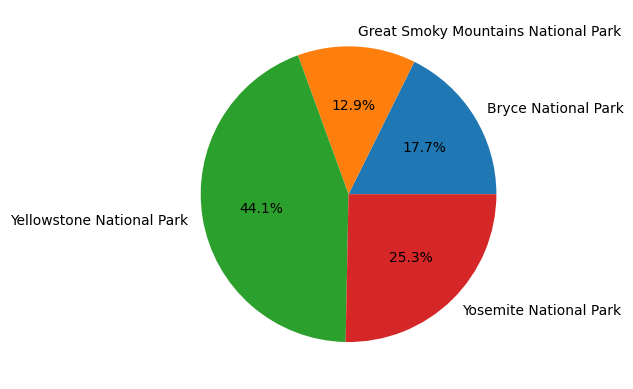

,park_name,observations
0,Bryce National Park,2310
1,Great Smoky Mountains National Park,1687
2,Yellowstone National Park,5771
3,Yosemite National Park,3311


<Figure size 640x480 with 0 Axes>

In [80]:
bat_data = bat_observations.groupby('park_name')['observations'].sum().reset_index()

plt.pie(bat_data['observations'], autopct='%0.1f%%', labels=bat_data['park_name'])
plt.show()
plt.clf()
bat_data

Now let's see each park broken down by protected bats vs. non-protected bat sightings. It seems that every park except for the Great Smoky Mountains National Park has more sightings of protected bats than not. This could be considered a great sign for bats.

In [91]:
obs_by_park = bat_observations.groupby(['park_name', 'is_protected']).observations.sum().reset_index()
obs_by_park

,park_name,is_protected,observations
0,Bryce National Park,False,1183
1,Bryce National Park,True,1127
2,Great Smoky Mountains National Park,False,970
3,Great Smoky Mountains National Park,True,717
4,Yellowstone National Park,False,3045
5,Yellowstone National Park,True,2726
6,Yosemite National Park,False,1786
7,Yosemite National Park,True,1525


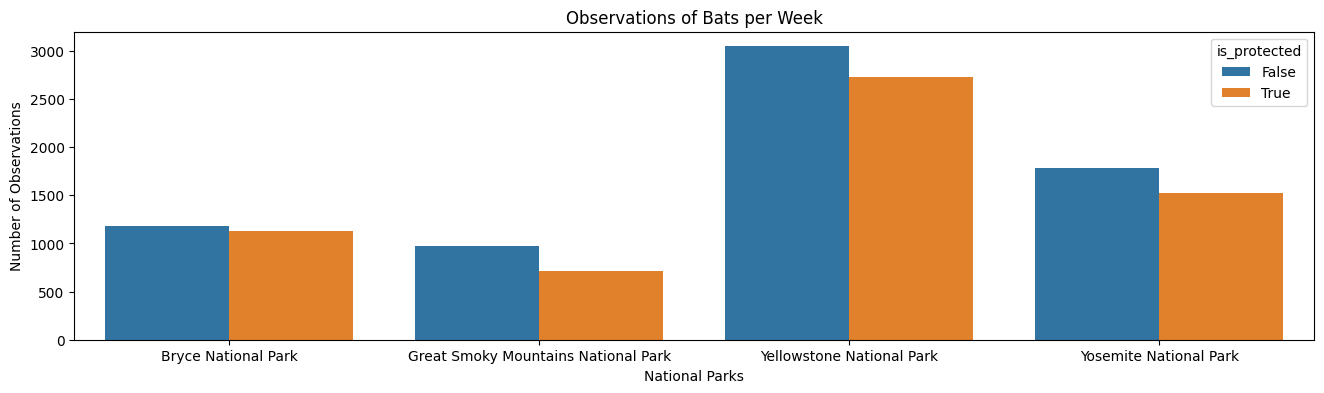

In [92]:
plt.figure(figsize=(16, 4))
sns.barplot(x=obs_by_park.park_name, y= obs_by_park.observations, hue=obs_by_park.is_protected)
plt.xlabel('National Parks')
plt.ylabel('Number of Observations')
plt.title('Observations of Bats per Week')
plt.show()

Above is a graph showing the proportion of observations of protected and non-protected bat species for each park. We can see that Yellowstone and Bryce National Parks get a lot of attention for their bat populations, as more protected bats are observed there compared to unprotected species. Great Smoky Mountains National Park may need to increase its conservation efforts as more unprotected species have been observed there.

## Observations - Analysis

The goal of this part will be:
- Checking the total sum of all observations 
- Checking the proportion of the number of observations of individual parks
- Analyse the proportions of the share of each category in the observations 
- Analysis of the proportion of the share of each category in the observations of the parks

In [94]:
total_obserwations = observations['observations'].sum()
print(total_obserwations)

3314739


The observation table contains data on 3,314,739 observed individuals of all species in Bryce National Park, Great Smoky Mountains National Park, Yellowstone National Park and Yosemite National Park over the past 7 days.

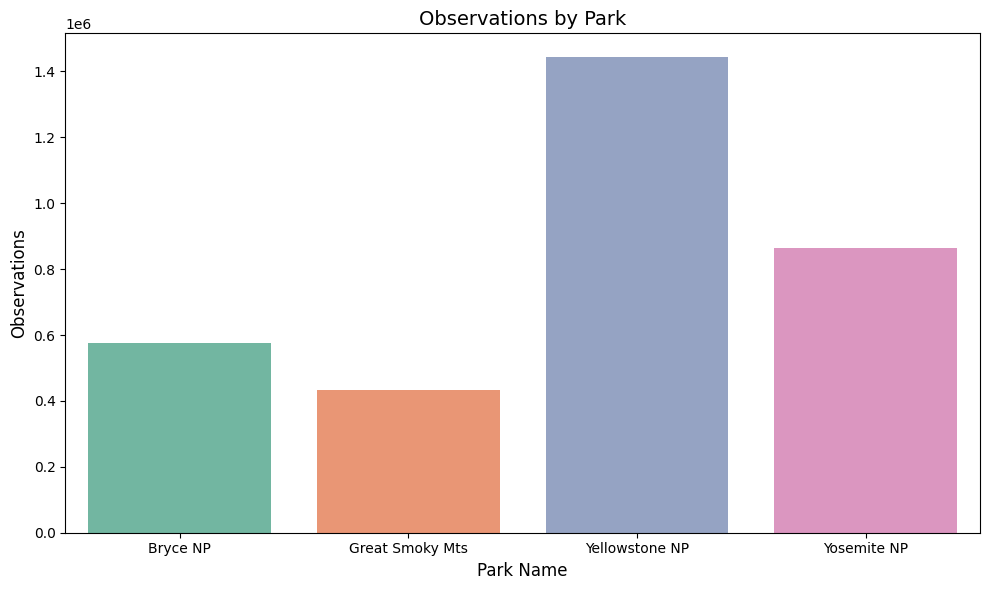

,park_name,observations,park_name_short
0,Bryce National Park,576025,Bryce NP
1,Great Smoky Mountains National Park,431820,Great Smoky Mts
2,Yellowstone National Park,1443562,Yellowstone NP
3,Yosemite National Park,863332,Yosemite NP


In [113]:
obserwations_by_park = observations.groupby('park_name')['observations'].sum().reset_index()
obserwations_by_park['park_name_short'] = ['Bryce NP', 'Great Smoky Mts', 'Yellowstone NP', 'Yosemite NP']


plt.figure(figsize=(10, 6))
sns.barplot(x='park_name_short', y='observations', data=obserwations_by_park, hue='park_name_short', palette='Set2', legend=False)
plt.xlabel('Park Name', fontsize=12)
plt.ylabel('Observations', fontsize=12)
plt.title('Observations by Park', fontsize=14)


plt.tight_layout()

plt.show()

obserwations_by_park

As we can see above the number of sightings in the parks varies. It must be assumed that this is a result of the size of the parks. Yellowstone National Park is the largest of all, while Yosemite National Park is the smallest.

In [105]:
observations_category = pd.merge(observations, species[['scientific_name', 'category']], on='scientific_name', how='left').reset_index(drop=True)
observations_category

,scientific_name,park_name,observations,category
0,Vicia benghalensis,Great Smoky Mountains National Park,68,Vascular Plant
1,Neovison vison,Great Smoky Mountains National Park,77,Mammal
2,Prunus subcordata,Yosemite National Park,138,Vascular Plant
3,Abutilon theophrasti,Bryce National Park,84,Vascular Plant
4,Githopsis specularioides,Great Smoky Mountains National Park,85,Vascular Plant
...,...,...,...,...
23311,Croton monanthogynus,Yosemite National Park,173,Vascular Plant
23312,Otospermophilus beecheyi,Bryce National Park,130,Mammal
23313,Heterotheca sessiliflora ssp. echioides,Bryce National Park,140,Vascular Plant
23314,Dicranella rufescens,Yosemite National Park,171,Nonvascular Plant


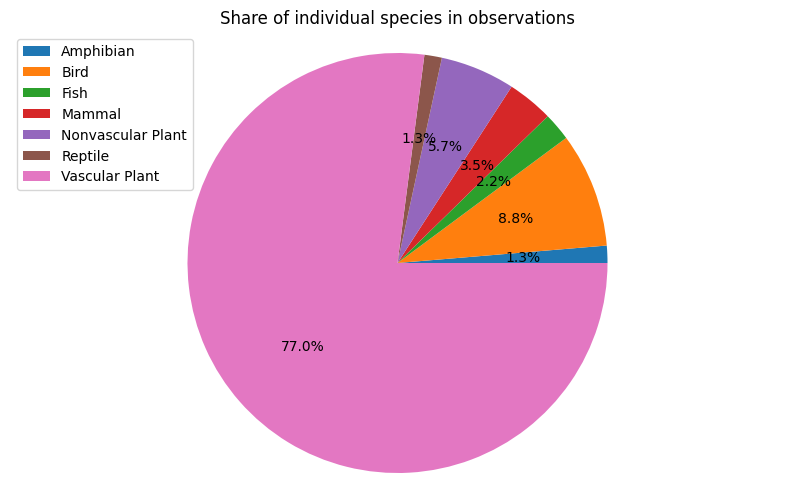

,category,observations
0,Amphibian,43971
1,Bird,292833
2,Fish,71631
3,Mammal,117411
4,Nonvascular Plant,190653
5,Reptile,44678
6,Vascular Plant,2555090


In [114]:
observations_by_category = observations_category.groupby(['category'])['observations'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.pie(observations_by_category['observations'], autopct='%0.1f%%')
plt.axis('equal')
plt.legend(observations_by_category['category'])
plt.title("Share of individual species in observations")
plt.show()

observations_by_category

In the graph above, we can see that plant observations (Nonvascular Plant and Vascular Plant) represent the vast majority, accounting for 82.7% of all observations.

Let's look at the distribution of observations for animals.

In [119]:
aggregated_observations_category = observations_category.groupby(['park_name', 'category'])['observations'].sum().reset_index()
aggregated_observations_category

,park_name,category,observations
0,Bryce National Park,Amphibian,7380
1,Bryce National Park,Bird,51647
2,Bryce National Park,Fish,12587
3,Bryce National Park,Mammal,20680
4,Bryce National Park,Nonvascular Plant,32992
5,Bryce National Park,Reptile,7950
6,Bryce National Park,Vascular Plant,443083
7,Great Smoky Mountains National Park,Amphibian,5707
8,Great Smoky Mountains National Park,Bird,37728
9,Great Smoky Mountains National Park,Fish,9306


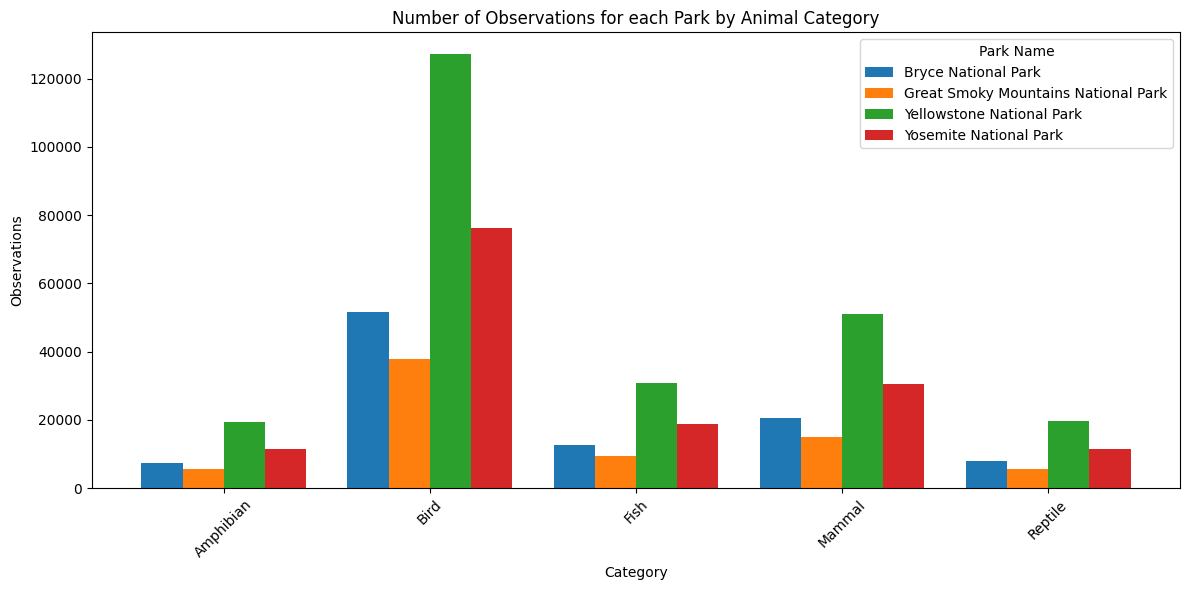

In [121]:
animals_categories = ['Amphibian', 'Bird', 'Fish', 'Mammal', 'Reptile']
parks = list(aggregated_observations_category['park_name'].unique())

data = np.array([[aggregated_observations_category[(aggregated_observations_category['category'] == category) & 
                                           (aggregated_observations_category['park_name'] == park)]['observations'].sum() 
                  for park in parks] 
                 for category in animals_categories])

width = 0.2
x = np.arange(len(animals_categories))



fig, ax = plt.subplots(figsize=(12, 6))
for i, park in enumerate(parks):
    ax.bar(x + i * width, data[:, i], width, label=park)

ax.set_xlabel('Category')
ax.set_ylabel('Observations')
ax.set_title('Number of Observations for each Park by Animal Category')
ax.set_xticks(x + width * (len(parks) - 1) / 2)
ax.set_xticklabels(animals_categories, rotation=45)
ax.legend(title="Park Name")
plt.tight_layout()
plt.show()

In the graph above, we can see that Yellowston tops the number of observations for each type of animal. We can also see that birds are the most numerous group of animals in the parks, while reptiles and amphibians are the least numerous.

Let's check the proportion of park observations for each species

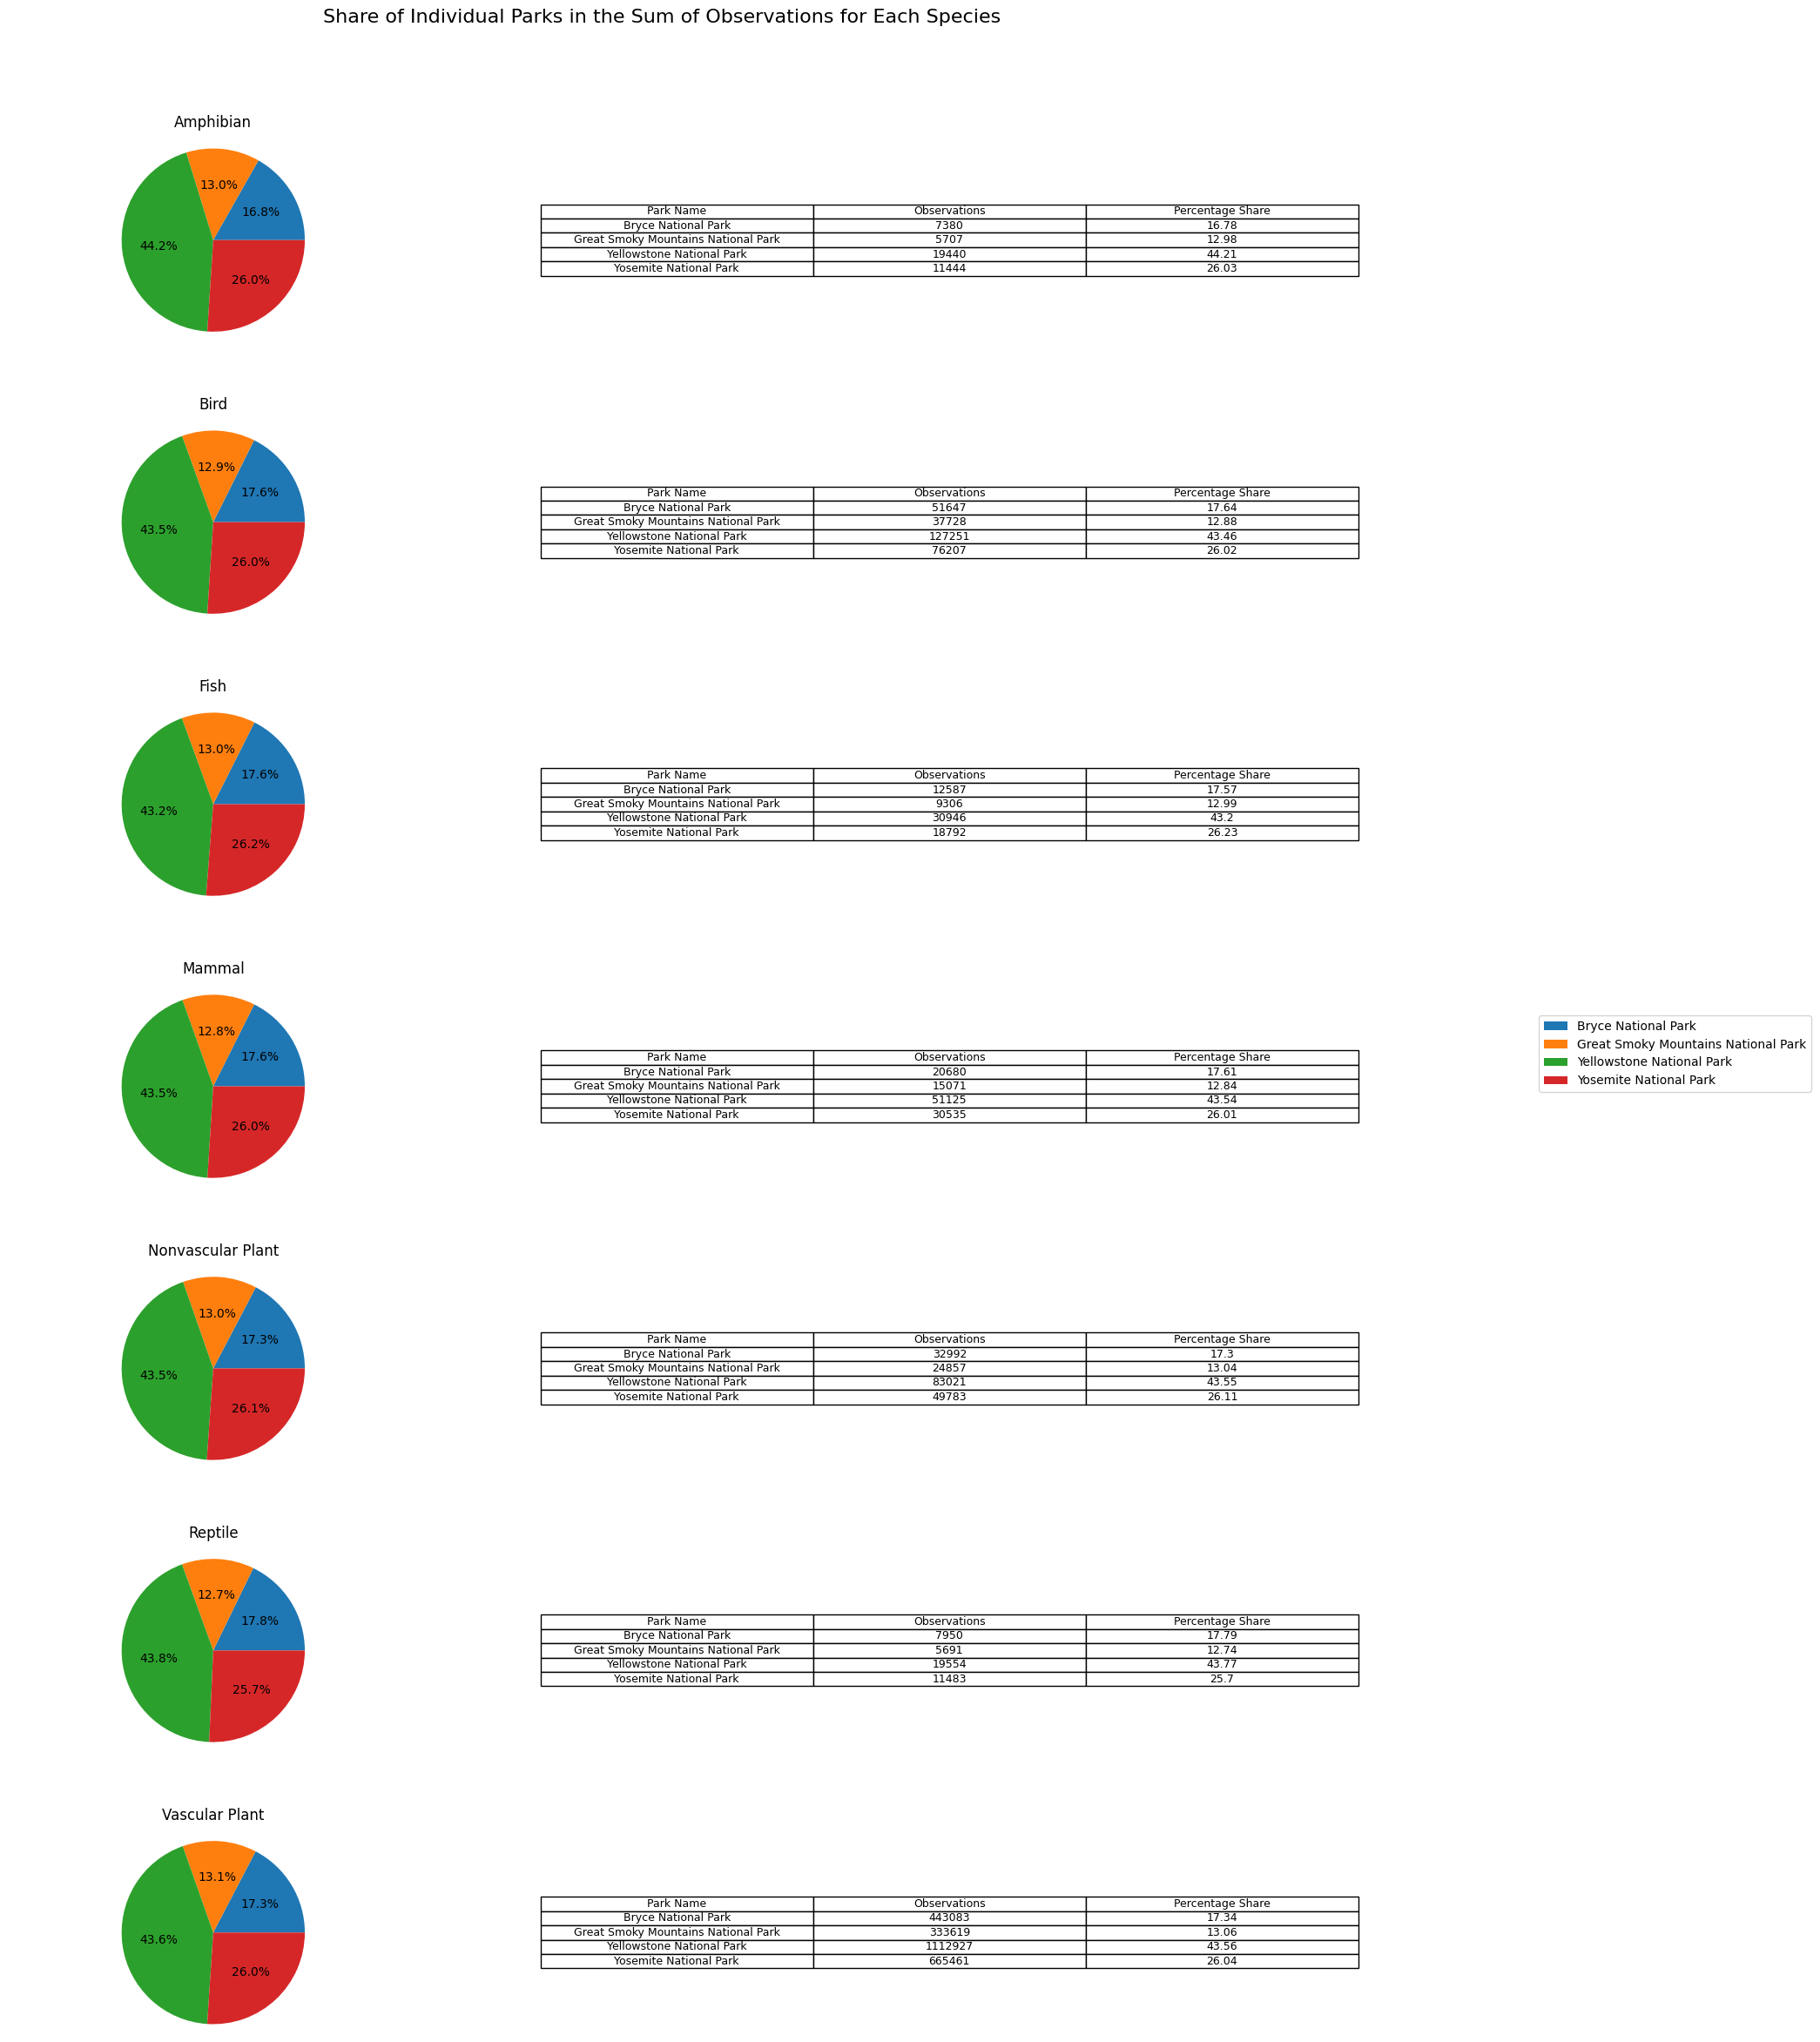

In [116]:
categories = list(aggregated_observations_category['category'].unique())
parks = list(aggregated_observations_category['park_name'].unique())

fig = plt.figure(figsize=(20, 25))

gs = GridSpec(7, 2, width_ratios=[1, 2])  # first column narrower - for pie charts, second wider - for tables

# create axes for pie charts and tables
axes = [fig.add_subplot(gs[i, 0]) for i in range(7)]  # First column: pie charts
axes += [fig.add_subplot(gs[i, 1]) for i in range(7)]  # Second column: tables

for i, category in enumerate(categories):
    # clear axes to ensure no residual elements
    axes[i].cla()
    axes[i + 7].cla()
    
    # filter data for the current category
    category_data = aggregated_observations_category[aggregated_observations_category['category'] == category]
    values = category_data[['park_name', 'observations']]
    
    # calculate the percentage share
    total_observations = values['observations'].sum()
    values['Percentage Share'] = round((values['observations'] / total_observations) * 100, 2)
    
    # plot the pie chart in the first column
    axes[i].pie(values['observations'], autopct='%0.1f%%')
    axes[i].set_title(category, fontsize=12, pad=10)
    axes[i].axis('equal')
    axes[i].set_axis_off()
    
    # add a table in the second column
    axes[i + 7].axis('off')
    table = axes[i + 7].table(
        cellText=values.values, 
        colLabels=['Park Name', 'Observations', 'Percentage Share'], 
        loc='center', 
        cellLoc='center'
    )
    
    # adjust the table font size
    table.set_fontsize(10)

# adjust the spacing of the entire figure
plt.subplots_adjust(top=0.92, bottom=0.05, hspace=0.4, wspace=0.2)

# add a title to the figure
fig.suptitle('Share of Individual Parks in the Sum of Observations for Each Species', fontsize=16)

# add a legend for the park names
park_names = aggregated_observations_category['park_name'].unique()
fig.legend(aggregated_observations_category['park_name'].unique(), loc='center left', bbox_to_anchor=(1, 0.5))


plt.show()

The above graphs indicate that the proportion of park observations for each of the species analysed is very close, almost equal. 

## Conclusions

The project made several data visualisations and conclusions about the different species and proportions of observations in the four national parks that made up this data set.

The project was also able to answer some of the questions posed at the beginning:

- What is the distribution of species' conservation status?
    - The vast majority of species were not protected (5 363 vs 180).
- Are certain types of species more threatened?
    - Mammals and birds had the highest percentage of protected species.
- Are the differences between species and their conservation status significant?
    - While mammals and birds had no significant difference in the percentage of protected species, mammals and reptiles showed a statistically significant difference.
- Which animals are most common and what is their distribution in the parks?
    - The study found that bats were most prevalent and most common in Yellowstone National Park.